# SherLock

## Load Libraries

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import pickle

In [2]:
pd.set_option('display.max_columns', None)

"awk '{if ($2 > 1458086400000 && $2 < 1459468800000) print$0 }' Userpresentprobe.tsv > Filtered_Userpresentprobe.tsv"

## Load Data

This will cycle through all the data found in the Kaggle subset data, 'archive'.

### Functions Used

In [3]:
# Functions
def editTextFile(f):
    # Read in the file
    with open(f, 'r') as file:
        filedata = file.read()

    # Replace the target string
    filedata = filedata.replace('[msec],size','[msec];size')

    # Write the file out again
    with open('editTextFile.txt', 'w') as file:
        file.write(filedata)
        
def magVector(df,col1,col2,col3):
    # Calculate magnitude of vector - SQRT(X^2 + Y^2 + Z^2)
    return ((df[col1].pow(2) + df[col2].pow(2) + df[col3].pow(2)).pow(1/2))        

### Loading

In [4]:
filename = './Filtered_anon_Bluetooth.tsv'
header_list = ['userid','uuid','bluetooth_appearance','bluetooth_class','bluetooth_maddress',
               'bluetooth_mremotebrsf','bluetooth_mvaluenrec','bluetooth_mvaluewbs','bluetooth_name',
               'bluetooth_rssi','bluetooth_timestamp']
Bluetooth_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['bluetooth_timestamp'])
Bluetooth_tsv['uuid'] = (pd.to_datetime(Bluetooth_tsv['uuid'], unit='ms'))      # Convert to datatime
Bluetooth_tsv = Bluetooth_tsv.sort_values(by='uuid')                            # Unsorted, so sorting required
#Bluetooth_tsv = Bluetooth_tsv.set_index('uuid')
Bluetooth_tsv = Bluetooth_tsv.drop(columns=['bluetooth_mremotebrsf',
                                            'bluetooth_mvaluenrec',
                                            'bluetooth_mvaluewbs']) # Nan's and singular values, depricated
print('Shape: ', Bluetooth_tsv.shape)
BluetoothUsers = Bluetooth_tsv['userid'].unique()
print('Unique users: ', len(BluetoothUsers))
Bluetooth_tsv.head(1)

Shape:  (163537, 8)
Unique users:  43


,userid,uuid,bluetooth_appearance,bluetooth_class,bluetooth_maddress,bluetooth_name,bluetooth_rssi,bluetooth_timestamp
104936,bca57e81a1,2016-03-16 00:00:28.684,0.0,5898764,14617fbaa958d2b,dfbf1f088ebff75,-76,2016-03-16 02:00:01.522


In [5]:
filename = './Filtered_Moriartyprobe.tsv'
header_list = ['userid','uuid','details','action','actionType','sessionType','Mor_version','sessionID','behavior']
Moriarty_tsv = pd.read_csv(filename, sep='\t', names=header_list)
Moriarty_tsv['uuid'] = (pd.to_datetime(Moriarty_tsv['uuid'], unit='ms'))     # Convert to datatime
Moriarty_tsv = Moriarty_tsv.sort_values(by='uuid')                           # Unsorted, so sorting required
#Moriarty_tsv = Moriarty_tsv.set_index('uuid')
#print(Moriarty_tsv['userid'].unique())
print('Shape: ', Moriarty_tsv.shape)
MoriartyUsers = Moriarty_tsv['userid'].unique()
print('Unique users: ', len(MoriartyUsers))
Moriarty_tsv.head(1)

Shape:  (101257, 9)
Unique users:  31


,userid,uuid,details,action,actionType,sessionType,Mor_version,sessionID,behavior
17728,6e200090ee,2016-03-16 00:01:54.501,Begin photo theft from gallery(actor);Active-T...,Reading File(s),malicious,malicious,3.0,2002,NaN


In [6]:
# Feature cleaning: drop odd states
#print(Moriarty_tsv['actionType'].unique())
#print(Moriarty_tsv[Moriarty_tsv['actionType'] == 'html'].shape)
#print(Moriarty_tsv[Moriarty_tsv['actionType'] == 'javascript'].shape)
#Moriarty_tsv = Moriarty_tsv.drop(Moriarty_tsv[(Moriarty_tsv['actionType'] == 'html') | 
#                                              (Moriarty_tsv['actionType'] == 'javascript')].index)
# Feature cleaning: drop v from version
#Moriarty_tsv['version'] = Moriarty_tsv['version'].astype(str).map(lambda x: x.lstrip('v'))

In [7]:
filename = './Filtered_Screenon.tsv'
header_list = ['userid','uuid','screenon','screenon_timestamp']
Screenon_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['screenon_timestamp'])
Screenon_tsv['uuid'] = (pd.to_datetime(Screenon_tsv['uuid'], unit='ms'))
Screenon_tsv = Screenon_tsv.sort_values(by='uuid')
#Screenon_tsv = Screenon_tsv.set_index('uuid')
Screenon_tsv['screenon'] = Screenon_tsv['screenon'].astype(int)                    # Original True:On / False:Off
#print(Screenon_tsv['userid'].unique())
print('Shape: ', Screenon_tsv.shape)
ScreenonUsers = Screenon_tsv['userid'].unique()
print('Unique users: ', len(ScreenonUsers))
Screenon_tsv.head(1)

Shape:  (131035, 4)
Unique users:  43


,userid,uuid,screenon,screenon_timestamp
51509,860550d355,2016-03-16 00:00:15.895,0,2016-03-16 02:00:15.892


In [8]:
filename = './Filtered_a_anon_T1.tsv'
header_list = ['userid','uuid','t1_version','googleplayloc_speed','googleplayloc_maccuracy',
               'googleplayloc_timestamp','celltower_cid','celltower_lac','celltower_psc',
               'celltower_timestamp','celltower_type','status_alarmvol','status_brightnessmode',
               'status_brightness_file','status_brightness_settings','status_dtmfvol','status_musicvol',
               'status_notificationvol','status_orientation','status_ringermode','status_ringtonevol',
               'status_systemvol','status_voicecallvol','status_timestamp',
               'location_spatio_5means','location_spatio_10means','location_spatio_25means',
               'location_spatio_50means','location_spatio_75means','location_spatio_100means',
               'location_spatioTemporal_day_5means','location_spatioTemporal_day_25means',
               'location_spatioTemporal_day_100means','location_spatioTemporal_week_5means',
               'location_spatioTemporal_week_25means','location_spatioTemporal_week_100means']
T1_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['googleplayloc_timestamp',
                                                                        'celltower_timestamp',
                                                                        'status_timestamp'])
T1_tsv['uuid'] = (pd.to_datetime(T1_tsv['uuid'], unit='ms'))
T1_tsv = T1_tsv.sort_values(by='uuid')
#T1_tsv = T1_tsv.set_index('uuid')
print('Shape: ', T1_tsv.shape)
T1Users = T1_tsv['userid'].unique()
print('Unique users: ', len(T1Users))
T1_tsv.head(1)

Shape:  (662195, 36)
Unique users:  43


,userid,uuid,t1_version,googleplayloc_speed,googleplayloc_maccuracy,googleplayloc_timestamp,celltower_cid,celltower_lac,celltower_psc,celltower_timestamp,celltower_type,status_alarmvol,status_brightnessmode,status_brightness_file,status_brightness_settings,status_dtmfvol,status_musicvol,status_notificationvol,status_orientation,status_ringermode,status_ringtonevol,status_systemvol,status_voicecallvol,status_timestamp,location_spatio_5means,location_spatio_10means,location_spatio_25means,location_spatio_50means,location_spatio_75means,location_spatio_100means,location_spatioTemporal_day_5means,location_spatioTemporal_day_25means,location_spatioTemporal_day_100means,location_spatioTemporal_week_5means,location_spatioTemporal_week_25means,location_spatioTemporal_week_100means
0,0a50e09262,2016-03-16 00:00:01.840,2.1.3,1.200375,43.0,2016-03-16 01:59:33.909,99b8dbfcca059d7,5c91a35489d4236,5d0f8c37711cf91,2016-03-16 01:59:21.759,1.0,15.0,Auto,0.0,231.0,15.0,15.0,7.0,Portrait,Normal,15.0,7.0,4.0,2016-03-16 01:59:21.825,4.0,9.0,12.0,12.0,33.0,10.0,5.0,13.0,16.0,5.0,19.0,97.0


In [9]:
filename = './Filtered_T4_filtered.tsv'
header_list = ['userid','uuid','t4_version','CpuHertz','CPU_0','CPU_1','CPU_2','CPU_3','Total_CPU',
               'TotalMemory_freeSize','TotalMemory_max_size','TotalMemory_total_size','TotalMemory_used_size',
               'Traffic_MobileRxBytes','Traffic_MobileRxPackets','Traffic_MobileTxBytes',
               'Traffic_MobileTxPackets','Traffic_TotalRxBytes','Traffic_TotalRxPackets','Traffic_TotalTxBytes',
               'Traffic_TotalTxPackets','Traffic_TotalWifiRxBytes','Traffic_TotalWifiRxPackets',
               'Traffic_TotalWifiTxBytes','Traffic_TotalWifiTxPackets','Traffic_timestamp','Battery_charge_type',
               'Battery_current_avg','Battery_health','Battery_icon_small','Battery_invalid_charger',
               'Battery_level','Battery_online','Battery_plugged','Battery_present','Battery_scale',
               'Battery_status','Battery_technology','Battery_temperature','Battery_timestamp','Battery_voltage',
               'MemTotal','MemFree','Buffers','Cached','SwapCached','Active','Inactive','Active_anon',
               'Inactive_anon','Active_file','Inactive_file','Unevictable','Mlocked','HighTotal','HighFree',
               'LowTotal','LowFree','SwapTotal','SwapFree','Dirty','Writeback','AnonPages','Mapped',
               'Shmem','Slab','SReclaimable','SUnreclaim','KernelStack','PageTables','CommitLimit','Committed_AS',
               'VmallocTotal','VmallocUsed','VmallocChunk','msmgpio_cpu0','msmgpio_sum_cpu123','wcd9xxx_cpu0',
               'wcd9xxx_sum_cpu123','pn547_cpu0','pn547_sum_cpu123','cypress_touchkey_cpu0',
               'cypress_touchkey_sum_cpu123','synaptics_rmi4_i2c_cpu0','synaptics_rmi4_i2c_sum_cpu123',
               'sec_headset_detect_cpu0','sec_headset_detect_sum_cpu123','flip_cover_cpu0','flip_cover_sum_cpu123',
               'home_key_cpu0','home_key_sum_cpu123','volume_down_cpu0','volume_down_sum_cpu123','volume_up_cpu0',
               'volume_up_sum_cpu123','companion_cpu0','companion_sum_cpu123','SLIMBUS_cpu0','SLIMBUS_sum_cpu123',
               'function_call_interrupts_cpu0','function_call_interrupts_sum_cpu123','cpu123_intr_prs','tot_user',
               'tot_nice','tot_system','tot_idle','tot_iowait','tot_irq','tot_softirq','ctxt','btime','processes',
               'procs_running','procs_blocked','connectedWifi_SSID','connectedWifi_Level', '117','118','119',
              '120', '121','122','123','124','125','126','127','128','129','130']
T4_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['Traffic_timestamp'])
T4_tsv['uuid'] = (pd.to_datetime(T4_tsv['uuid'], unit='ms'))
T4_tsv = T4_tsv.drop(columns=['Battery_charge_type','Battery_current_avg','Battery_health','Battery_icon_small',
                              'Battery_invalid_charger','Battery_level','Battery_online','Battery_plugged',
                              'Battery_present','Battery_scale','Battery_status','Battery_technology',
                              'Battery_temperature','Battery_timestamp','Battery_voltage','MemTotal','MemFree',
                              'Buffers','Cached','SwapCached','Active','Inactive','Active_anon','Inactive_anon',
                              'Active_file','Inactive_file','Unevictable','Mlocked','HighTotal','HighFree',
                              'LowTotal','LowFree','SwapTotal','SwapFree','Dirty','Writeback','AnonPages','Mapped',
                              'Shmem','Slab','SReclaimable','SUnreclaim','KernelStack','PageTables','CommitLimit',
                              'Committed_AS','VmallocTotal','VmallocUsed','VmallocChunk','msmgpio_cpu0',
                              'msmgpio_sum_cpu123','wcd9xxx_cpu0','wcd9xxx_sum_cpu123','pn547_cpu0',
                              'pn547_sum_cpu123','cypress_touchkey_cpu0','cypress_touchkey_sum_cpu123',
                              'synaptics_rmi4_i2c_cpu0','synaptics_rmi4_i2c_sum_cpu123','sec_headset_detect_cpu0',
                              'sec_headset_detect_sum_cpu123','flip_cover_cpu0','flip_cover_sum_cpu123',
                              'home_key_cpu0','home_key_sum_cpu123','volume_down_cpu0','volume_down_sum_cpu123',
                              'volume_up_cpu0','volume_up_sum_cpu123','companion_cpu0','companion_sum_cpu123',
                              'SLIMBUS_cpu0','SLIMBUS_sum_cpu123','function_call_interrupts_cpu0',
                              'function_call_interrupts_sum_cpu123','cpu123_intr_prs','tot_user','tot_nice',
                              'tot_system','tot_idle','tot_iowait','tot_irq','tot_softirq','ctxt','btime',
                              'processes','procs_running','procs_blocked','connectedWifi_SSID',
                              'connectedWifi_Level','117','118','119','120', '121','122','123','124','125','126',
                              '127','128','129','130'])
T4_tsv = T4_tsv.sort_values(by='uuid')
#T4_tsv = T4_tsv.set_index('uuid')
print('Shape: ', T4_tsv.shape)
T4Users = T4_tsv['userid'].unique()
print('Unique users: ', len(T4Users))
T4_tsv.head(1)

/Users/kent/opt/anaconda3/envs/sherlock/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,34,37,39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Shape:  (2359469, 26)
Unique users:  13


,userid,uuid,t4_version,CpuHertz,CPU_0,CPU_1,CPU_2,CPU_3,Total_CPU,TotalMemory_freeSize,TotalMemory_max_size,TotalMemory_total_size,TotalMemory_used_size,Traffic_MobileRxBytes,Traffic_MobileRxPackets,Traffic_MobileTxBytes,Traffic_MobileTxPackets,Traffic_TotalRxBytes,Traffic_TotalRxPackets,Traffic_TotalTxBytes,Traffic_TotalTxPackets,Traffic_TotalWifiRxBytes,Traffic_TotalWifiRxPackets,Traffic_TotalWifiTxBytes,Traffic_TotalWifiTxPackets,Traffic_timestamp
937807,3e9c54bce7,2016-03-16 00:00:00.861,2.1.4,2.4 GHz,0.0,0.0,0.0,0.0,0.0,4732148.0,134217728.0,51235530.0,46503382.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-03-16 02:00:00.768


In [10]:
#T4_dropList = T4_tsv.columns[T4_tsv.isna().any()].tolist()
#T4_NaNCounts = T4_tsv[T4_tsv.columns[T4_tsv.isnull().any()]].isnull().sum().sort_values(ascending=True)

In [11]:
filename = './Filtered_Userpresentprobe.tsv'
header_list = ['userid', 'uuid', 'userpresent_timestamp']
Userpresentprobe_tsv = pd.read_csv(filename, sep='\t', names=header_list, parse_dates=['userpresent_timestamp'])
Userpresentprobe_tsv['uuid'] = (pd.to_datetime(Userpresentprobe_tsv['uuid'], unit='ms'))
Userpresentprobe_tsv = Userpresentprobe_tsv.sort_values(by='uuid')
#Userpresentprobe_tsv = Userpresentprobe_tsv.set_index('uuid')
Userpresentprobe_tsv['UP_status'] = 1                    # Added column as a marker
print('Shape: ', Userpresentprobe_tsv.shape)
UserpresentprobeUsers = Userpresentprobe_tsv['userid'].unique()
print('Unique users: ', len(UserpresentprobeUsers))
Userpresentprobe_tsv.head(1)

Shape:  (37034, 4)
Unique users:  43


,userid,uuid,userpresent_timestamp,UP_status
34518,fd2db8f0be,2016-03-16 00:24:50.086,2016-03-16 02:24:50.078,1


In [12]:
filename = './Filtered_anon_Wifi.lineendings.tsv'
header_list = ['userid', 'uuid', 'ssid','capabilities','freq','level']
Wifi_tsv = pd.read_csv(filename, sep='\t', names=header_list)
Wifi_tsv['uuid'] = (pd.to_datetime(Wifi_tsv['uuid'], unit='ms'))
Wifi_tsv = Wifi_tsv.sort_values(by='uuid')
#Wifi_tsv = Wifi_tsv.set_index('uuid')
print('Shape: ', Wifi_tsv.shape)
WifiUsers = Wifi_tsv['userid'].unique()
print('Unique users: ', len(WifiUsers))
Wifi_tsv.head(1)

Shape:  (2355475, 6)
Unique users:  43


,userid,uuid,ssid,capabilities,freq,level
1165746,8960d74df5,2016-03-16 00:00:08.258,cf0a8cd77830521,[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][ESS],2437,NaN


## EDA

#### Moriarty exploration

In [13]:
print('Moriarty Sessions: ', Moriarty_tsv.sessionType.count())
print(Moriarty_tsv.groupby('sessionType')['uuid'].nunique())
Moriarty_tsv.groupby('actionType')['uuid'].nunique()
# should drop the non-benign/malicious....

Moriarty Sessions:  101257
sessionType
benign        1100
malicious    99874
Name: uuid, dtype: int64


actionType
benign          483
malicious    100491
Name: uuid, dtype: int64

In [14]:
print(Moriarty_tsv['sessionID'].value_counts().sort_values())
#Moriarty_tsv['sessionID'].unique()
#Moriarty_tsv.groupby(['sessionID', 'sessionType']).count()

#Moriarty_tsv[Moriarty_tsv['sessionID'] == 15]
Moriarty_tsv[Moriarty_tsv['sessionID'].astype(str) == 'v3.0']  # FAILS

18          1
30          1
32          1
2009        4
1017        4
28          4
8           5
2           5
1013        5
24          6
16          6
10          8
1019        8
4          12
22         15
14         15
12         17
1          19
20         33
6          40
1012      133
1020      169
9         199
1014      203
33        465
35        478
1016      578
0         932
3        1044
2006     1208
29       1382
2012     1439
2014     1490
31       1630
2002     1806
2000     1885
2004     2261
2008     2278
23       2720
1022     3149
27       3158
11       3372
25       3463
2010     3507
7        6328
13       6782
21       9672
17      11444
19      11748
15      16125
Name: sessionID, dtype: int64


,userid,uuid,details,action,actionType,sessionType,Mor_version,sessionID,behavior


In [15]:
pd.set_option('display.max_rows', 100)
Moriarty_tsv.head(10)

,userid,uuid,details,action,actionType,sessionType,Mor_version,sessionID,behavior
17728,6e200090ee,2016-03-16 00:01:54.501,Begin photo theft from gallery(actor);Active-T...,Reading File(s),malicious,malicious,3.0,2002,NaN
17757,6e200090ee,2016-03-16 00:01:54.514,Searching for new photos to steal from the gal...,Reading File(s),malicious,malicious,3.0,2002,NaN
17523,6e200090ee,2016-03-16 00:01:54.525,Didn't found a new photo(actor);Active-Thief,Reading File(s),malicious,malicious,3.0,2002,NaN
21825,6fec24656a,2016-03-16 00:03:22.267,Begin photo theft from gallery(actor);Active-T...,Reading File(s),malicious,malicious,3.0,3,NaN
21836,6fec24656a,2016-03-16 00:03:22.283,Searching for new photos to steal from the gal...,Reading File(s),malicious,malicious,3.0,3,NaN
21829,6fec24656a,2016-03-16 00:03:22.315,Didn't found a new photo(actor);Active-Thief,Reading File(s),malicious,malicious,3.0,3,NaN
90171,e22b9f3772,2016-03-16 00:03:48.234,searching for wifi,Probing for WiFi access,malicious,malicious,3.0,19,NaN
90529,e22b9f3772,2016-03-16 00:03:48.239,Response: Wifi available,Probing for WiFi access,malicious,malicious,3.0,19,NaN
90293,e22b9f3772,2016-03-16 00:03:48.263,Begin photo/video theft from gallery(actor);Ba...,Reading File(s),malicious,malicious,3.0,19,NaN
90051,e22b9f3772,2016-03-16 00:03:48.269,Searching for new photos/videos to steal from ...,Reading File(s),malicious,malicious,3.0,19,NaN


In [16]:
pd.set_option('display.max_rows', 15)

Benign actions

In [17]:
Moriarty_tsv[Moriarty_tsv["actionType"] == "benign"][["details", "action"]]

,details,action
97855,Start of stats reading service,Service Launch
67551,Start of stats reading service,Service Launch
21955,App entered onCreate(),App Mode Change
22018,App entered onResume(),App Mode Change
21975,App entered onPause(),App Mode Change
...,...,...
61725,App entered onCreate(),App Mode Change
61724,App entered onResume(),App Mode Change
61719,App entered onPause(),App Mode Change
9623,Start of stats reading service,Service Launch


Malicious

In [18]:
Moriarty_tsv[Moriarty_tsv["actionType"] == "malicious"][["details", "action"]]

,details,action
17728,Begin photo theft from gallery(actor);Active-T...,Reading File(s)
17757,Searching for new photos to steal from the gal...,Reading File(s)
17523,Didn't found a new photo(actor);Active-Thief,Reading File(s)
21825,Begin photo theft from gallery(actor);Active-T...,Reading File(s)
21836,Searching for new photos to steal from the gal...,Reading File(s)
...,...,...
9632,Begin photo theft from gallery(actor);Active-T...,Reading File(s)
9660,Searching for new photos to steal from the gal...,Reading File(s)
9662,Didn't found a new photo(actor);Active-Thief,Reading File(s)
9650,searching for wifi,Probing for WiFi access


In [19]:
                                                  #NEED TO SUBDIVIDE BY VERSION
mSessList = Moriarty_tsv['sessionID'].unique()
minT = []
maxT = []

for i, ses in enumerate(mSessList):
    x = Moriarty_tsv[Moriarty_tsv['sessionID'] == ses]['uuid'].min()
    y = Moriarty_tsv[Moriarty_tsv['sessionID'] == ses]['uuid'].max()
    minT.append(x)
    maxT.append(y)

MoriartySessions = pd.concat([pd.Series(mSessList,name='sessionID'),
                              pd.Series(minT,name='minT'),
                              pd.Series(maxT,name='maxT')], axis=1)
MoriartySessions['Duration'] = MoriartySessions['maxT'] - MoriartySessions['minT']
MoriartySessions

,sessionID,minT,maxT,Duration
0,2002,2016-03-16 00:01:54.501,2016-03-17 10:00:10.224,1 days 09:58:15.723000
1,3,2016-03-16 00:03:22.267,2016-03-18 05:14:51.256,2 days 05:11:28.989000
2,19,2016-03-16 00:03:48.234,2016-03-31 08:58:11.063,15 days 08:54:22.829000
3,2008,2016-03-16 01:14:40.794,2016-03-29 08:57:41.357,13 days 07:43:00.563000
4,11,2016-03-16 02:06:47.710,2016-03-27 08:52:22.110,11 days 06:45:34.400000
...,...,...,...,...
45,1022,2016-03-30 11:07:35.583,2016-03-31 10:57:35.454,0 days 23:49:59.871000
46,35,2016-03-30 11:51:44.088,2016-03-31 08:34:38.343,0 days 20:42:54.255000
47,2014,2016-03-30 16:16:21.252,2016-03-31 14:05:25.215,0 days 21:49:03.963000
48,30,2016-03-30 19:18:18.379,2016-03-30 19:18:18.379,0 days 00:00:00


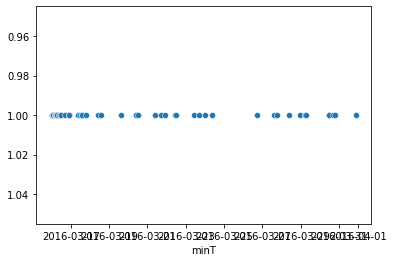

In [20]:
# Time series plots of moriarty
sns.scatterplot(data=MoriartySessions, x='minT', y=1)
plt.gca().invert_yaxis()
plt.show()

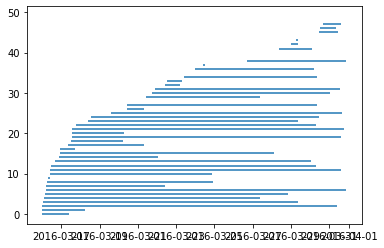

In [21]:
# Duration of moriarty
#sns.scatterplot(data=MoriartySessions, x='sessionID', y='Duration')
#plt.gca().invert_yaxis()
#plt.show()
# need to find different x axis, time

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dt

fig = plt.figure()
ax = fig.add_subplot(111)
ax = ax.xaxis_date()
ax = plt.hlines(MoriartySessions.index, dt.date2num(MoriartySessions.minT), dt.date2num(MoriartySessions.maxT))

In [22]:
# plot intra-session moriarty behavorior

## Feature engineering of Moriarty

In [23]:
binary = {'benign': 0, 'malicious': 1}
Moriarty_tsv = Moriarty_tsv.replace({'actionType':binary})
Moriarty_tsv = Moriarty_tsv.replace({'sessionType':binary})
Moriarty_tsv

,userid,uuid,details,action,actionType,sessionType,Mor_version,sessionID,behavior
17728,6e200090ee,2016-03-16 00:01:54.501,Begin photo theft from gallery(actor);Active-T...,Reading File(s),1,1,3.0,2002,NaN
17757,6e200090ee,2016-03-16 00:01:54.514,Searching for new photos to steal from the gal...,Reading File(s),1,1,3.0,2002,NaN
17523,6e200090ee,2016-03-16 00:01:54.525,Didn't found a new photo(actor);Active-Thief,Reading File(s),1,1,3.0,2002,NaN
21825,6fec24656a,2016-03-16 00:03:22.267,Begin photo theft from gallery(actor);Active-T...,Reading File(s),1,1,3.0,3,NaN
21836,6fec24656a,2016-03-16 00:03:22.283,Searching for new photos to steal from the gal...,Reading File(s),1,1,3.0,3,NaN
...,...,...,...,...,...,...,...,...,...
9660,56d7a3b146,2016-03-31 21:10:41.323,Searching for new photos to steal from the gal...,Reading File(s),1,1,3.0,2000,NaN
9662,56d7a3b146,2016-03-31 21:10:41.324,Didn't found a new photo(actor);Active-Thief,Reading File(s),1,1,3.0,2000,NaN
9650,56d7a3b146,2016-03-31 21:11:04.602,searching for wifi,Probing for WiFi access,1,1,3.0,2000,NaN
9645,56d7a3b146,2016-03-31 21:11:23.881,searching for wifi,Probing for WiFi access,1,1,3.0,2000,NaN


### Sensors

In [24]:
#T2['magAccel'] = magVector(T2,'AccelerometerStat_x_MIDDLE_SAMPLE',
#                           'AccelerometerStat_y_MIDDLE_SAMPLE',
#                           'AccelerometerStat_z_MIDDLE_SAMPLE')
#T2['magMag'] = magVector(T2,'MagneticField_x_MIDDLE_SAMPLE',
#                           'MagneticField_y_MIDDLE_SAMPLE',
#                           'MagneticField_z_MIDDLE_SAMPLE')
#T2.head(3)

In [25]:
# plots of sensors in time...

## Extract Moriarty across datasets

In [26]:
#pd.Series(Moriarty_tsv.uuid.values,index=Moriarty_tsv.uuid.values).to_dict()

### Screen On

In [27]:
# Combine T4 with append with Moriarty 
Merged = T4_tsv.append(Moriarty_tsv, sort=True)
Merged = Merged.sort_values(by='uuid')

# Pad downwards into T4
Merged[['actionType', 'sessionType']] = Merged[['actionType', 'sessionType']].fillna(method='pad', limit=5)  #5 rows only

# Delete everything that is not Moriarty or within ____ samples from Moriarty
Merged = Merged.dropna(subset=['sessionType'])
######################################################
# Combine Merged with append with Screenon
Merged = Merged.append(Screenon_tsv, sort=True)
Merged = Merged.sort_values(by='uuid')
print(Merged.shape)

# Pad downwards into T4
Merged[['actionType', 'sessionType']] = Merged[['actionType', 'sessionType']].fillna(method='pad', limit=5)  #5 rows only

# Delete everything that is not Moriarty or within ____ samples from Moriarty
Merged = Merged.dropna(subset=['sessionType'])
######################################################
# Combine Merged with append with T1
Merged = Merged.append(T1_tsv, sort=True)
Merged = Merged.sort_values(by='uuid')
print(Merged.shape)

# Pad downwards into T4
Merged[['actionType', 'sessionType']] = Merged[['actionType', 'sessionType']].fillna(method='pad', limit=5)  #5 rows only

# Delete everything that is not Moriarty or within ____ samples from Moriarty
Merged = Merged.dropna(subset=['sessionType'])
######################################################
# Combine Merged with append with Bluetooth
Merged = Merged.append(Bluetooth_tsv, sort=True)
Merged = Merged.sort_values(by='uuid')
print(Merged.shape)

# Pad downwards into T4
Merged[['actionType', 'sessionType']] = Merged[['actionType', 'sessionType']].fillna(method='pad', limit=5)  #5 rows only

# Delete everything that is not Moriarty or within ____ samples from Moriarty
Merged = Merged.dropna(subset=['sessionType'])
######################################################
# Combine Merged with append with Userpresentprobe
Merged = Merged.append(Userpresentprobe_tsv, sort=True)
Merged = Merged.sort_values(by='uuid')
print(Merged.shape)

# Pad downwards into T4
Merged[['actionType', 'sessionType']] = Merged[['actionType', 'sessionType']].fillna(method='pad', limit=5)  #5 rows only

# Delete everything that is not Moriarty or within ____ samples from Moriarty
Merged = Merged.dropna(subset=['sessionType'])
######################################################
# Combine Merged with append with Wifi
Merged = Merged.append(Wifi_tsv, sort=True)
Merged = Merged.sort_values(by='uuid')
print(Merged.shape)

# Pad downwards into T4
Merged[['actionType', 'sessionType']] = Merged[['actionType', 'sessionType']].fillna(method='pad', limit=5)  #5 rows only

# Delete everything that is not Moriarty or within ____ samples from Moriarty
Merged = Merged.dropna(subset=['sessionType'])
#Merged.head(20)

(376717, 35)
(971524, 69)
(725265, 75)
(714328, 77)
(3066311, 81)


In [28]:
print('Moriarty Sessions: ', Merged.sessionType.count())
print(Merged.groupby('sessionType')['uuid'].nunique())
Merged.groupby('actionType')['uuid'].nunique()
# should drop the non-benign/malicious....

Moriarty Sessions:  1631914
sessionType
0.0     10690
1.0    859088
Name: uuid, dtype: int64


actionType
0.0      6384
1.0    863394
Name: uuid, dtype: int64

# Perform true merges on exact uuid

In [29]:
# TSV
#print('Bluetooth_tsv.shape ', Bluetooth_tsv.shape)
#print('Moriarty_tsv.shape  ', Moriarty_tsv.shape)
#print('Screenon_tsv.shape  ', Screenon_tsv.shape)
#print('T1_tsv.shape        ', T1_tsv.shape)
#print('T4_tsv              ', T4_tsv.shape)
#print('Userpresentprobe_tsv',Userpresentprobe_tsv.shape)
#print('Wifi_tsv            ',Wifi_tsv.shape)

#print('M+Blue     ',pd.merge(left=Moriarty_tsv, right=Bluetooth_tsv, how='outer',left_on='uuid', right_on='uuid').shape)
#print('M+Screen   ',pd.merge(left=Moriarty_tsv, right=Screenon_tsv,  how='outer',left_on='uuid', right_on='uuid').shape)
#print('M+T1       ',pd.merge(left=Moriarty_tsv, right=T1_tsv,        how='outer',left_on='uuid', right_on='uuid').shape)
#print('M+T4       ',pd.merge(left=Moriarty_tsv, right=T4_tsv,        how='outer',left_on='uuid', right_on='uuid').shape)
#print('M+User     ',pd.merge(left=Moriarty_tsv, right=Userpresentprobe_tsv, how='outer', left_on='uuid', right_on='uuid').shape)
#print('M+Wifi     ',pd.merge(left=Moriarty_tsv, right=Wifi_tsv, how='outer', left_on='uuid', right_on='uuid').shape)

#test = pd.merge(Moriarty_tsv, Bluetooth_tsv, how='left',on=['uuid', 'uuid'])
#test = pd.merge(test, Screenon_tsv, how='left',on=['uuid', 'uuid'])
#test = pd.merge(test, T1_tsv, how='left',on=['uuid', 'uuid'])
#test = pd.merge(test, T4_tsv, how='left',on=['uuid', 'uuid'])
#test = pd.merge(test, Userpresentprobe_tsv, how='left',on=['uuid', 'uuid'])
#test = pd.merge(test, Wifi_tsv, how='left',on=['uuid', 'uuid'])
#test = test.dropna(subset=['action'])
#print('test.shape  ', test.shape)
#test.head(20)



#print('T4+T1   ',pd.merge(left=T4_tsv, right=T1_tsv, how='outer',left_on='uuid', right_on='uuid').shape)
#T4T1_exact = pd.merge(left=T4_tsv, right=T1_tsv, how='outer',left_on='uuid', right_on='uuid')
#T4_exact = T4T1_exact.dropna(subset=['Traffic_timestamp'])
#T4_exact.head(100)

#Moriarty_tsv['uuid'].dt.round('1s').head()
#T4_tsv['uuid'].dt.round('1s').head()
#print('M+T4 ROUNDED     ',pd.merge(left=Moriarty_tsv, right=Bluetooth_tsv, left_on='uuidROUND', right_on='uuidROUND').shape)

#pd.merge(left=Moriarty_tsv, right=Screenon_tsv, how='outer', left_on='uuid', right_on='uuid').head(20)


#print(pd.merge(left=Moriarty_tsv, right=Userpresentprobe_tsv, left_on='uuid', right_on='uuid').shape)
#merged_left = pd.merge(left=Moriarty_tsv, right=Screenon_tsv, how='left', left_on='uuid', right_on='uuid')
#merged_left.tail(200)

# Populate by unique user

In [30]:
for user in MoriartyUsers:
    print(user, T4_tsv[T4_tsv['userid'] == user].shape)

6e200090ee (0, 26)
6fec24656a (0, 26)
e22b9f3772 (0, 26)
55153967c4 (164446, 26)
8ef449026a (0, 26)
5c1f751a99 (230820, 26)
56d7a3b146 (140231, 26)
cfdf8f8818 (0, 26)
d35184bc22 (0, 26)
ec3b3592f1 (0, 26)
68a5ffab20 (0, 26)
b63c849327 (0, 26)
5e9275b594 (229206, 26)
b298fa1895 (0, 26)
5b76bedcac (233659, 26)
73e9841e35 (0, 26)
72edf5f08f (0, 26)
aa2e99301a (0, 26)
e0bf6beeb3 (0, 26)
f68d404dec (0, 26)
97bb95f55a (0, 26)
860550d355 (0, 26)
d8d16595c6 (0, 26)
bca57e81a1 (0, 26)
dd25a68e9e (0, 26)
1775bd8416 (247413, 26)
abd6f757b8 (0, 26)
9f7c0cf3ba (0, 26)
fd2db8f0be (0, 26)
8960d74df5 (0, 26)
3e9c54bce7 (81200, 26)


In [31]:
# Create blank merging dataframe
MergedByUniqUser = pd.DataFrame()

for user in MoriartyUsers:
    # Extract for unique user
    dfMor = Moriarty_tsv[Moriarty_tsv['userid'] == user]
    print(user, 'occurs', dfMor.shape[0], 'times in Moriarty')

    # Combine T4 with append with Moriarty
    #print(user, 'occurs in T4  ', T4_tsv[T4_tsv['userid'] == user].shape)
    dfT4 = T4_tsv[T4_tsv['userid'] == user]
    dfT4Mor = pd.merge(dfT4, dfMor, how='outer',on=['uuid', 'uuid'])
    dfT4Mor = dfT4Mor.sort_values(by='uuid')
    #print('dfT4Mor.shape after merge', dfT4Mor.shape)
    # Pad malicious downwards into T4
    #dfT4Mor[['actionType', 'sessionType']] = dfT4Mor[['actionType', 'sessionType']].fillna(method='pad', limit=1)  #1 rows only
    dfT4Mor = dfT4Mor.fillna(method='pad', limit=10)  #10 rows only 
    # replace NaN's with benign / benign?

    # Combine T1 with append with Moriarty
    #print(user, 'occurs in T1  ', T1_tsv[T1_tsv['userid'] == user].shape)
    dfT1 = T1_tsv[T1_tsv['userid'] == user]
    dfT1Mor = pd.merge(dfT1, dfMor, how='outer',on=['uuid', 'uuid'])
    dfT1Mor = dfT1Mor.sort_values(by='uuid')
    #print('dfT1Mor.shape after merge', dfT1Mor.shape)
    # Pad malicious downwards into T1
    #dfT1Mor[['actionType', 'sessionType']] = dfT1Mor[['actionType', 'sessionType']].fillna(method='pad', limit=1)  #1 rows only
    dfT1Mor = dfT1Mor.fillna(method='pad', limit=10)  #10 rows only 
    # replace NaN's with benign / benign?

    # Combine Screenon with append with Moriarty
    #print(user, 'occurs in Screenon  ', Screenon_tsv[Screenon_tsv['userid'] == user].shape)
    dfScreenon = Screenon_tsv[Screenon_tsv['userid'] == user]
    dfScreenonMor = pd.merge(dfScreenon, dfMor, how='outer',on=['uuid', 'uuid'])
    dfScreenonMor = dfScreenonMor.sort_values(by='uuid')
    #print('dfScreenonMor.shape after merge', dfScreenonMor.shape)
    # Pad malicious downwards into Screenon
    #dfScreenonMor[['actionType', 'sessionType']] = dfScreenonMor[['actionType', 'sessionType']].fillna(method='pad', limit=1)  #1 rows only
    dfScreenonMor = dfScreenonMor.fillna(method='pad', limit=10)  #10 rows only 
    # replace NaN's with benign / benign?
    
    # Combine Userpresent with append with Moriarty
    #print(user, 'occurs in Userpresent  ', Userpresent_tsv[Userpresent_tsv['userid'] == user].shape)
    dfUserpresent = Userpresentprobe_tsv[Userpresentprobe_tsv['userid'] == user]
    dfUserpresentMor = pd.merge(dfUserpresent, dfMor, how='outer',on=['uuid', 'uuid'])
    dfUserpresentMor = dfUserpresentMor.sort_values(by='uuid')
    #print('dfUserpresentMor.shape after merge', dfUserpresentMor.shape)
    # Pad malicious downwards into Userpresent
    #dfUserpresentMor[['actionType', 'sessionType']] = dfUserpresentMor[['actionType', 'sessionType']].fillna(method='pad', limit=1)  #1 rows only
    dfUserpresentMor = dfUserpresentMor.fillna(method='pad', limit=10)  #10 rows only 
    # replace NaN's with benign / benign?

    # Combine Bluetooth with append with Moriarty
    #print(user, 'occurs in Bluetooth  ', Bluetooth_tsv[Bluetooth_tsv['userid'] == user].shape)
    dfBluetooth = Bluetooth_tsv[Bluetooth_tsv['userid'] == user]
    dfBluetoothMor = pd.merge(dfBluetooth, dfMor, how='outer',on=['uuid', 'uuid'])
    dfBluetoothMor = dfBluetoothMor.sort_values(by='uuid')
    #print('dfBluetoothMor.shape after merge', dfBluetoothMor.shape)
    # Pad malicious downwards into Bluetooth
    #dfBluetoothMor[['actionType', 'sessionType']] = dfBluetoothMor[['actionType', 'sessionType']].fillna(method='pad', limit=1)  #1 rows only
    dfBluetoothMor = dfBluetoothMor.fillna(method='pad', limit=10)  #10 rows only 
    # replace NaN's with benign / benign?

    # Below is kinda whatever, but get's data out the door...
    
    # Merging of different dataframes
    dfTempMerge = dfT4Mor.append([dfT1Mor, dfScreenonMor, dfUserpresentMor, dfBluetoothMor], sort=True)
    dfTempMerge = dfTempMerge.sort_values(by='uuid')
    dfTempMerge = dfTempMerge.fillna(method='pad')
    dfTempMerge = dfTempMerge.drop_duplicates()
    #print('outputdf.shape', dfTempMerge.shape)

    MergedByUniqUser = MergedByUniqUser.append(dfTempMerge)
    print(MergedByUniqUser.shape)

MergedByUniqUser = MergedByUniqUser.sort_values(by='uuid') 
MergedByUniqUser = MergedByUniqUser.drop_duplicates()
print('MergedByUniqUser.shape', MergedByUniqUser.shape)
MergedByUniqUser.tail(20)

6e200090ee occurs 4343 times in Moriarty
(28588, 78)
6fec24656a occurs 922 times in Moriarty
(37836, 78)
e22b9f3772 occurs 7954 times in Moriarty
(71724, 78)
55153967c4 occurs 3671 times in Moriarty
(263285, 78)
8ef449026a occurs 4414 times in Moriarty
(295149, 78)
5c1f751a99 occurs 1421 times in Moriarty
(550291, 78)
56d7a3b146 occurs 1885 times in Moriarty
(712605, 78)
cfdf8f8818 occurs 179 times in Moriarty
(727835, 78)
d35184bc22 occurs 303 times in Moriarty
(755857, 78)
ec3b3592f1 occurs 327 times in Moriarty
(780351, 78)
68a5ffab20 occurs 267 times in Moriarty
(806324, 78)
b63c849327 occurs 1083 times in Moriarty
(833332, 78)
5e9275b594 occurs 3936 times in Moriarty
(1097039, 78)
b298fa1895 occurs 5793 times in Moriarty
(1131610, 78)
5b76bedcac occurs 2180 times in Moriarty
(1385187, 78)
73e9841e35 occurs 7850 times in Moriarty
(1418833, 78)
72edf5f08f occurs 6519 times in Moriarty
(1454090, 78)
aa2e99301a occurs 3717 times in Moriarty
(1487670, 78)
e0bf6beeb3 occurs 13745 times 

,CPU_0,CPU_1,CPU_2,CPU_3,CpuHertz,Mor_version,TotalMemory_freeSize,TotalMemory_max_size,TotalMemory_total_size,TotalMemory_used_size,Total_CPU,Traffic_MobileRxBytes,Traffic_MobileRxPackets,Traffic_MobileTxBytes,Traffic_MobileTxPackets,Traffic_TotalRxBytes,Traffic_TotalRxPackets,Traffic_TotalTxBytes,Traffic_TotalTxPackets,Traffic_TotalWifiRxBytes,Traffic_TotalWifiRxPackets,Traffic_TotalWifiTxBytes,Traffic_TotalWifiTxPackets,Traffic_timestamp,UP_status,action,actionType,behavior,bluetooth_appearance,bluetooth_class,bluetooth_maddress,bluetooth_name,bluetooth_rssi,bluetooth_timestamp,celltower_cid,celltower_lac,celltower_psc,celltower_timestamp,celltower_type,details,googleplayloc_maccuracy,googleplayloc_speed,googleplayloc_timestamp,location_spatioTemporal_day_100means,location_spatioTemporal_day_25means,location_spatioTemporal_day_5means,location_spatioTemporal_week_100means,location_spatioTemporal_week_25means,location_spatioTemporal_week_5means,location_spatio_100means,location_spatio_10means,location_spatio_25means,location_spatio_50means,location_spatio_5means,location_spatio_75means,screenon,screenon_timestamp,sessionID,sessionType,status_alarmvol,status_brightness_file,status_brightness_settings,status_brightnessmode,status_dtmfvol,status_musicvol,status_notificationvol,status_orientation,status_ringermode,status_ringtonevol,status_systemvol,status_timestamp,status_voicecallvol,t1_version,t4_version,userid_x,userid_y,userpresent_timestamp,uuid
229203,14.285715,0.0,93.750000,5.882353,2.4 GHz,3.0,14019872.0,134217728.0,36156080.0,22136208.0,28.479517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-04-01 02:59:45.487,1.0,Reading File(s),1.0,NaN,0.0,1312384.0,06d1bda765bd65c,226bba36e7facd3,-104.0,2016-04-01 02:01:25.153,d21af96b65da5f3,15c7432e6f43af7,96e2a1d38c298ed,2016-04-01 02:59:09.678,1.0,Searching for new photos to steal from the gal...,36.218,0.000000,2016-04-01 02:59:09.845,51.0,24.0,4.0,69.0,3.0,2.0,80.0,2.0,25.0,6.0,1.0,16.0,0.0,2016-04-01 02:59:13.964,35.0,1.0,11.0,0.0,134.0,Auto,0.0,4.0,0.0,Portrait,Normal,0.0,0.0,2016-04-01 02:59:09.687,5.0,2.1.4,2.1.4,5e9275b594,5e9275b594,2016-04-01 01:39:16.043,2016-03-31 23:59:45.563000000
19467,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1.0,Reading File(s),1.0,NaN,0.0,2098184.0,35b036a1a88bcea,fc1b4f014f0f716,-99.0,2016-03-31 20:24:26.682,fc1b4f014f0f716,fc1b4f014f0f716,fc1b4f014f0f716,2016-04-01 02:59:06.693,0.0,Didn't found a new photo(actor);Active-Thief,48.000,2.735928,2016-04-01 02:53:25.397,39.0,11.0,5.0,20.0,2.0,5.0,8.0,6.0,7.0,37.0,3.0,66.0,0.0,2016-03-31 23:39:06.613,2014.0,1.0,11.0,0.0,134.0,Auto,0.0,15.0,0.0,Portrait,Normal,0.0,0.0,2016-04-01 02:59:06.718,0.0,2.1.3,NaN,b298fa1895,b298fa1895,2016-03-31 22:14:52.709,2016-03-31 23:59:46.769999872
18236,31.250000,20.0,0.000000,23.529411,2.4 GHz,3.0,3844088.0,134217728.0,31356520.0,27512432.0,18.694853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-04-01 02:59:43.204,1.0,Reading File(s),1.0,NaN,0.0,7936.0,1eaa4bd28c33de2,47b32663a7f1e71,-112.0,2016-03-31 22:11:08.021,5b4fb38e2ba325b,e6fe77b140f3d19,8abe479aaa1ec14,2016-04-01 02:59:08.266,1.0,Didn't found a new photo(actor);Active-Thief,42.000,0.000000,2016-03-31 12:32:43.393,45.0,13.0,2.0,59.0,19.0,4.0,32.0,6.0,22.0,12.0,5.0,48.0,1.0,2016-03-31 22:10:06.920,31.0,1.0,11.0,0.0,134.0,Auto,2.0,0.0,7.0,Portrait,Normal,2.0,1.0,2016-04-01 02:59:08.263,5.0,2.1.4,2.1.4,5c1f751a99,5c1f751a99,2016-03-31 21:53:06.098,2016-03-31 23:59:48.284999936
8351,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,1.0,Send to server,1.0,NaN,0.0,5898764.0,10a3f197d5ce4aa,a3c90635f0521d7,-86.0,2016-03-31 21:28:16.661,8b8f6146368989f,13dadf6c9b5b86f,968023314bbc547,2016-04-01 02:59:08.242,1.0,"Successful send to server(duration [ms],size [...",40.500,0.000000,2016-04-01 02:59:20.565,77.0,8.0,5.0,88.0,5.0,5.0,39.0,3.0,15.0,5.0,4.0,46.0,0.0,2016-04-01 02:17:02.647,0.0,0.0,4.0,0.0,74.0,Manu

In [32]:
filteredMerged = pd.DataFrame()

for index, row in MoriartySessions.iterrows():
    data = Merged[(Merged['UUID'] > row['minT']) & (Merged['UUID'] < row['maxT'])]
    filteredMerged = filteredMerged.append(data, ignore_index=True)
    
filteredMerged[['SessionID', 'SessionType', 'Version']] = filteredMerged[['SessionID', 'SessionType', 'Version']].fillna(method="pad")

KeyError: 'UUID'

In [ ]:
# next steps - integer encode unique - aggregate Success...
filteredMerged['Details'].unique()

In [ ]:
#unit type action type
#malicious vs benigin

In [ ]:
###### predict is screen on from magnitude

In [ ]:
#### predict screen on moriarty...

In [ ]:
sns.distplot(T2['AccelerometerStat_x_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_x_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

### Goofy stuff

In [ ]:
t2_accelero = T2[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE',
                  'pressure_MIDDLE_SAMPLE']]

t2_accelero.isnull().values.any()
t2_accelero = t2_accelero.dropna()
t2_accelero.isnull().values.any()

t2_accelero_X = t2_accelero[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE']]
t2_accelero_y = t2_accelero[['pressure_MIDDLE_SAMPLE']]

X_train, X_test, y_train, y_test = train_test_split(t2_accelero_X, t2_accelero_y, random_state=42)

### Pipeline for pipeline assignment

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

Pretty poor, eh?  Well, what would you expect from a random grab...

### Pickle the model

In [ ]:
with open('model.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(pipe, f, pickle.HIGHEST_PROTOCOL)

### Create faux-data

In [ ]:
print(X_test[0:2].values.tolist())

In [ ]:
#Export as json
import json

data = X_test[0:2].values.tolist()

with open('testdata.json', 'w') as f:
    json.dump(data, f)

### Tests

In [ ]:
from newdata import newdata
newdata

In [ ]:
with open('model.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    pipePKL = pickle.load(f)

In [ ]:
predictions = pipePKL.predict(newdata)
print(predictions)